In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM



Using TensorFlow backend.


In [2]:
import numpy as np

In [3]:
gt = read_csv('pca_df.csv')

In [4]:
list(gt)

['PC1',
 'PC2',
 'PC3',
 'PC4',
 'PC5',
 'PC6',
 'PC7',
 'PC8',
 'PC9',
 'PC10',
 'PC11',
 'PC12',
 'PC13',
 'PC14',
 'PC15',
 'PC16',
 'PC17',
 'PC18',
 'PC19',
 '.pose.pose.position.x',
 '.pose.pose.position.y',
 '.pose.pose.position.z',
 '.pose.pose.orientation.x',
 '.pose.pose.orientation.y',
 '.pose.pose.orientation.z',
 '.pose.pose.orientation.w']

In [5]:
print(gt.head())
gt = gt[[".pose.pose.position.x",".pose.pose.position.y",'.pose.pose.orientation.x','.pose.pose.orientation.y','.pose.pose.orientation.z','.pose.pose.orientation.w']]
gt = gt.values
print(gt)

        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.851072  8.044216  0.326841 -1.044230  2.307484  1.075863  3.638323   
1 -0.564265  8.143598  0.277990 -0.437284  1.891698  0.630888  3.733934   
2 -0.344030  8.164862  0.485255 -0.638983  1.044315  1.209261  3.248368   
3 -0.176959  8.179082  0.546207 -0.434098  0.953136  0.805202  3.497788   
4 -0.109958  8.211974  0.486941 -0.138914  0.705735  0.631348  3.641314   

        PC8       PC9      PC10            ...                 PC17      PC18  \
0  4.274178  2.717133 -0.704123            ...            -1.655194  1.958867   
1  1.592049  2.517208 -0.030412            ...             0.399774  1.910119   
2  4.415842  0.998141  0.345600            ...             1.202330  1.503087   
3  2.762791  1.320751  0.095173            ...             0.692561  2.706914   
4  3.152261  0.852382  0.061224            ...             0.396012  2.190524   

       PC19  .pose.pose.position.x  .pose.pose.position.y  \
0

In [6]:
ft = read_csv('pca_df.csv')
#print(ft)
ft = ft.values[:,0:19]
print(ft.shape)
print(gt.shape)

(18126, 19)
(18126, 6)


In [7]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg



In [8]:
# normalize features
ft_scaler = MinMaxScaler(feature_range=(-1, 1))
ft_sc = ft_scaler.fit_transform(ft)
#gt_scaler = MinMaxScaler(feature_range=(-1,1))
#gt_sc = gt_scaler.fit_transform(gt)
#specify the number of lag hours
gt_sc=gt
n_hours = 10
n_features = 19
# frame as supervised learning
reframed = series_to_supervised(ft_sc, n_hours, 1)
print(reframed.shape)
print(reframed.head())

(18116, 209)
    var1(t-10)  var2(t-10)  var3(t-10)  var4(t-10)  var5(t-10)  var6(t-10)  \
10   -0.715661    0.912124   -0.516294   -0.909127   -0.554948    0.013421   
11   -0.700331    0.923405   -0.518159   -0.886534   -0.576755   -0.040784   
12   -0.688560    0.925818   -0.510249   -0.894042   -0.621199    0.029671   
13   -0.679630    0.927432   -0.507923   -0.886416   -0.625981   -0.019550   
14   -0.676049    0.931166   -0.510185   -0.875428   -0.638956   -0.040728   

    var7(t-10)  var8(t-10)  var9(t-10)  var10(t-10)    ...     var10(t)  \
10    0.655249    0.553081    0.373648    -0.045019    ...    -0.018136   
11    0.673072    0.177793    0.345796    -0.021662    ...    -0.022740   
12    0.582559    0.572903    0.134165    -0.008627    ...    -0.041608   
13    0.629053    0.341605    0.179110    -0.017309    ...    -0.033457   
14    0.655807    0.396101    0.113858    -0.018486    ...    -0.022294   

    var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  var16(t)  var

In [9]:
# split into train and test sets
values = reframed.values
n_train_hours = 10000
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], gt_sc[:n_train_hours,:]
print(train_X)
print(train_y)
test_X, test_y = test[:, :n_obs], gt_sc[n_train_hours:,:]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
test_y = test_y[:-10,:]

[[-0.71566087  0.91212421 -0.51629433 ...  0.12552099 -0.07823277
  -0.27253581]
 [-0.7003313   0.92340481 -0.51815858 ...  0.22909346 -0.03023118
  -0.25335908]
 [-0.68855996  0.92581842 -0.51024888 ...  0.30560588  0.11326897
  -0.42811761]
 ...
 [-0.7607772  -0.12804698 -0.51093121 ...  0.02868932  0.0877397
  -0.48286006]
 [-0.77243001 -0.12919634 -0.5096666  ... -0.15797009  0.08266238
  -0.4530655 ]
 [-0.77116535 -0.13449095 -0.50725277 ...  0.13853906  0.15366004
  -0.44799775]]
[[ 0.90919352 -0.08681773  0.01089559  0.01093195 -0.31471806  0.94905971]
 [ 0.90946156 -0.0870174   0.01113683  0.01165991 -0.31471966  0.94904771]
 [ 0.90919352 -0.08681773  0.01089559  0.01093195 -0.31471806  0.94905971]
 ...
 [ 1.26979244  0.29782158  0.00141868  0.03304494  0.68734164  0.7255808 ]
 [ 1.24536765  0.29915699  0.00305932  0.03137151  0.68609035  0.7268332 ]
 [ 1.23623121  0.30100036  0.00363177  0.03080919  0.68503638  0.72784804]]
(10000, 190) 10000 (10000, 6)
(10000, 10, 19) (10000,

Train on 10000 samples, validate on 8116 samples
Epoch 1/200
 - 7s - loss: 0.4051 - val_loss: 0.4491
Epoch 2/200
 - 3s - loss: 0.3929 - val_loss: 0.4431
Epoch 3/200
 - 3s - loss: 0.3761 - val_loss: 0.4408
Epoch 4/200
 - 3s - loss: 0.3715 - val_loss: 0.4450
Epoch 5/200
 - 3s - loss: 0.3735 - val_loss: 0.4503
Epoch 6/200
 - 3s - loss: 0.3692 - val_loss: 0.4515
Epoch 7/200
 - 3s - loss: 0.3679 - val_loss: 0.4568
Epoch 8/200
 - 3s - loss: 0.3670 - val_loss: 0.4643
Epoch 9/200
 - 3s - loss: 0.3663 - val_loss: 0.4732
Epoch 10/200
 - 3s - loss: 0.3646 - val_loss: 0.4759
Epoch 11/200
 - 3s - loss: 0.3635 - val_loss: 0.4680
Epoch 12/200
 - 3s - loss: 0.3619 - val_loss: 0.4679
Epoch 13/200
 - 3s - loss: 0.3601 - val_loss: 0.4629
Epoch 14/200
 - 3s - loss: 0.3606 - val_loss: 0.4642
Epoch 15/200
 - 3s - loss: 0.3586 - val_loss: 0.4614
Epoch 16/200
 - 3s - loss: 0.3581 - val_loss: 0.4613
Epoch 17/200
 - 3s - loss: 0.3575 - val_loss: 0.4591
Epoch 18/200
 - 3s - loss: 0.3563 - val_loss: 0.4564
Epoch 

Epoch 154/200
 - 4s - loss: 0.1907 - val_loss: 0.4214
Epoch 155/200
 - 4s - loss: 0.1928 - val_loss: 0.4417
Epoch 156/200
 - 4s - loss: 0.1858 - val_loss: 0.4209
Epoch 157/200
 - 3s - loss: 0.1858 - val_loss: 0.4263
Epoch 158/200
 - 3s - loss: 0.1959 - val_loss: 0.4359
Epoch 159/200
 - 4s - loss: 0.1872 - val_loss: 0.4229
Epoch 160/200
 - 3s - loss: 0.1896 - val_loss: 0.4264
Epoch 161/200
 - 3s - loss: 0.1908 - val_loss: 0.4230
Epoch 162/200
 - 4s - loss: 0.1867 - val_loss: 0.4229
Epoch 163/200
 - 4s - loss: 0.1841 - val_loss: 0.4327
Epoch 164/200
 - 4s - loss: 0.1779 - val_loss: 0.4353
Epoch 165/200
 - 3s - loss: 0.1858 - val_loss: 0.4285
Epoch 166/200
 - 3s - loss: 0.1892 - val_loss: 0.4224
Epoch 167/200
 - 4s - loss: 0.1803 - val_loss: 0.4263
Epoch 168/200
 - 4s - loss: 0.1980 - val_loss: 0.4219
Epoch 169/200
 - 4s - loss: 0.1988 - val_loss: 0.4258
Epoch 170/200
 - 3s - loss: 0.1835 - val_loss: 0.4275
Epoch 171/200
 - 4s - loss: 0.1824 - val_loss: 0.4232
Epoch 172/200
 - 5s - loss: 

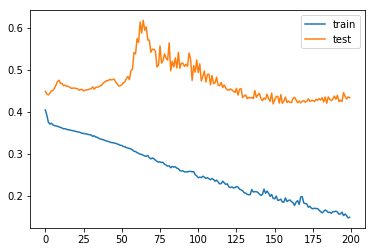

In [10]:

# design network
model = Sequential()
#model.add(Dense(50))
model.add(LSTM(100,input_shape=(train_X.shape[1],train_X.shape[2])))
#model.add(Dense(100))
#model.add(Dense(50))
model.add(Dense(6))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=200, batch_size=150, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [11]:
# make a prediction
yhat = model.predict(test_X)
yhat2 = model.predict(train_X)

# calculate RMSE
rmse = sqrt(mean_squared_error(yhat, test_y))
rmse2 = sqrt(mean_squared_error(yhat, test_y))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.729


In [12]:
x = np.linspace(0,ypred.shape[0], ypred.shape[0]).reshape(ypred.shape[0],)
ypred = model.predict(train_X)
pyplot.plot(ypred[:,1],'r')
pyplot.plot(train_y[:,1],'b')
error=np.abs(ypred[:,[1]]-train_y[:,[1]])
pyplot.fill_between(x,(ypred[:,[1]]-error).reshape(ypred.shape[0],), (ypred[:,[1]]+error).reshape(ypred.shape[0],))
pyplot.show()

NameError: name 'ypred' is not defined

In [13]:
yhat.shape

(8116, 6)

In [14]:
x = np.linspace(0,yhat.shape[0], yhat.shape[0]).reshape(yhat.shape[0],1)
x.shape

(8116, 1)

In [15]:
(yhat[:,[1]]-error).shape

NameError: name 'error' is not defined

In [16]:
import seaborn as sns

In [17]:
fmri = sns.load_dataset("fmri")

In [18]:
g = sns.relplot(x="timepoint", y="signal",data=

SyntaxError: unexpected EOF while parsing (<ipython-input-18-73c1be86b032>, line 1)

In [19]:
sns.set()
sns.set_context('notebook',font_scale=1.4)
pyplot.rcParams['figure.figsize']=(25,12)

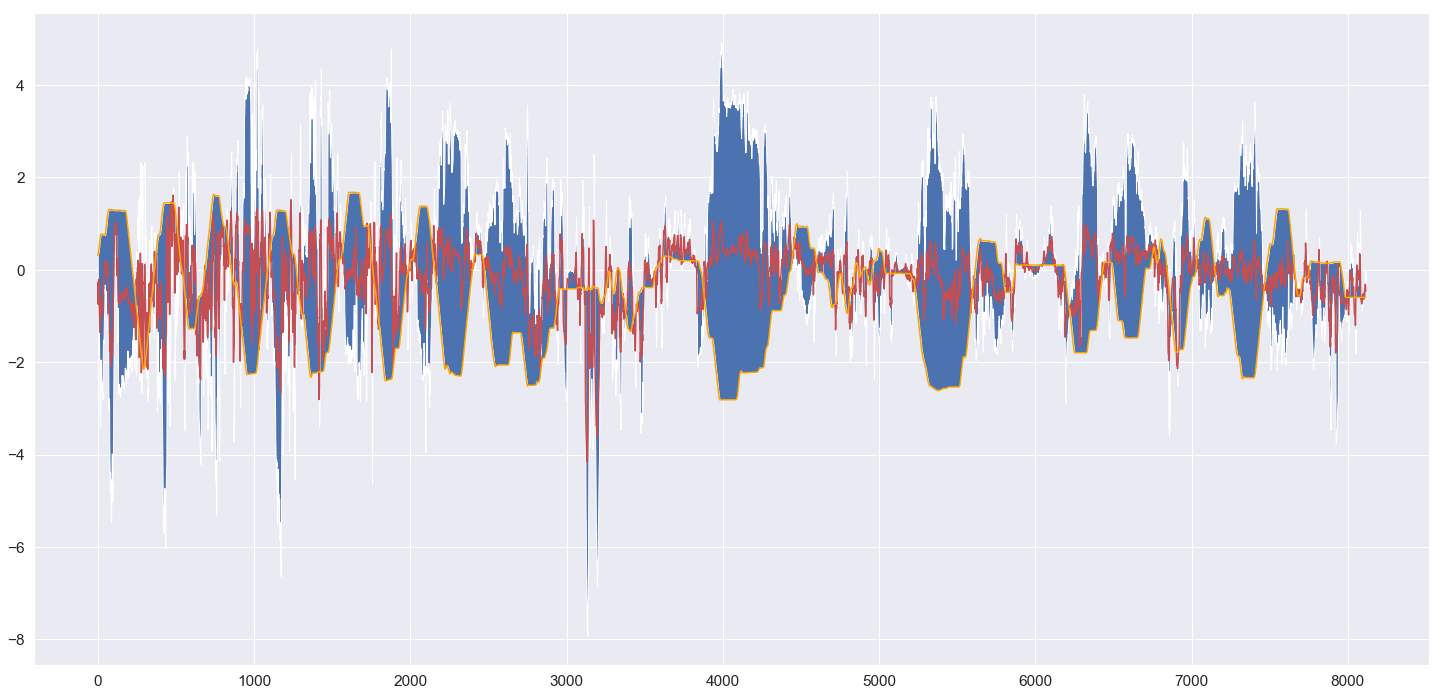

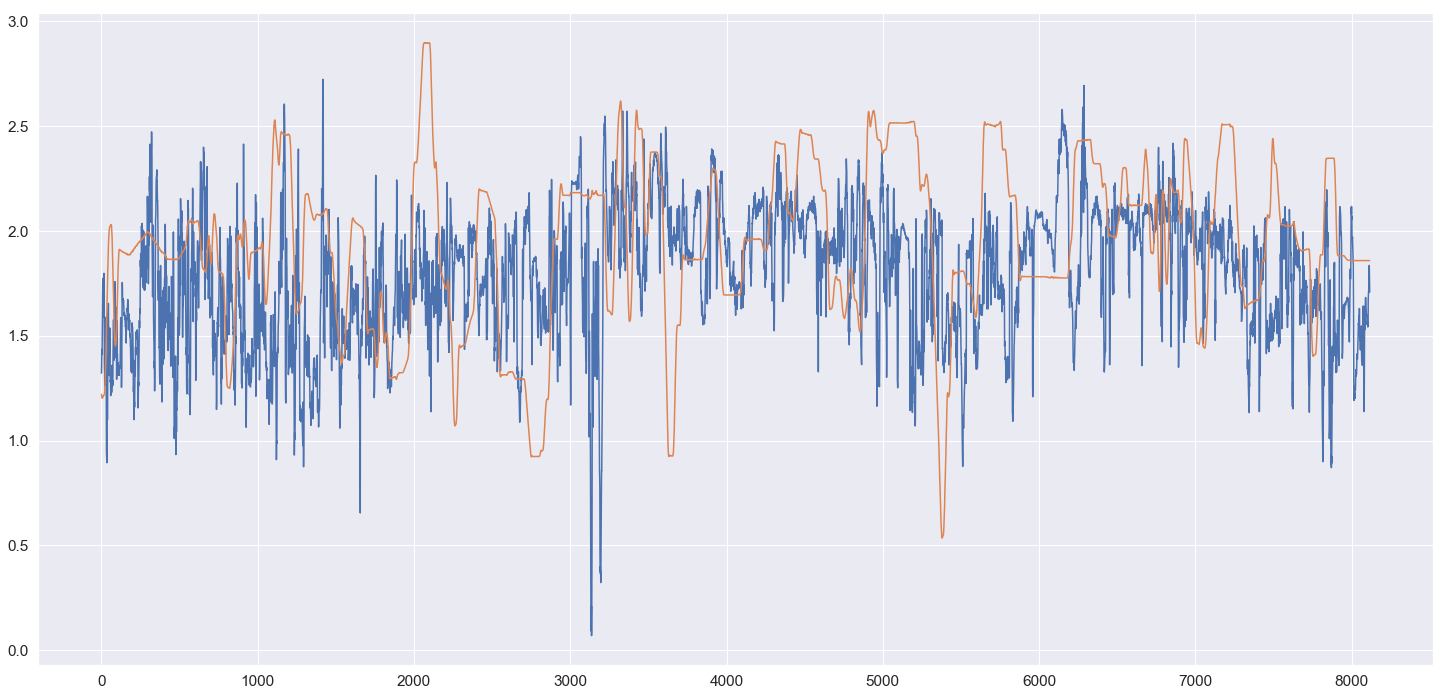

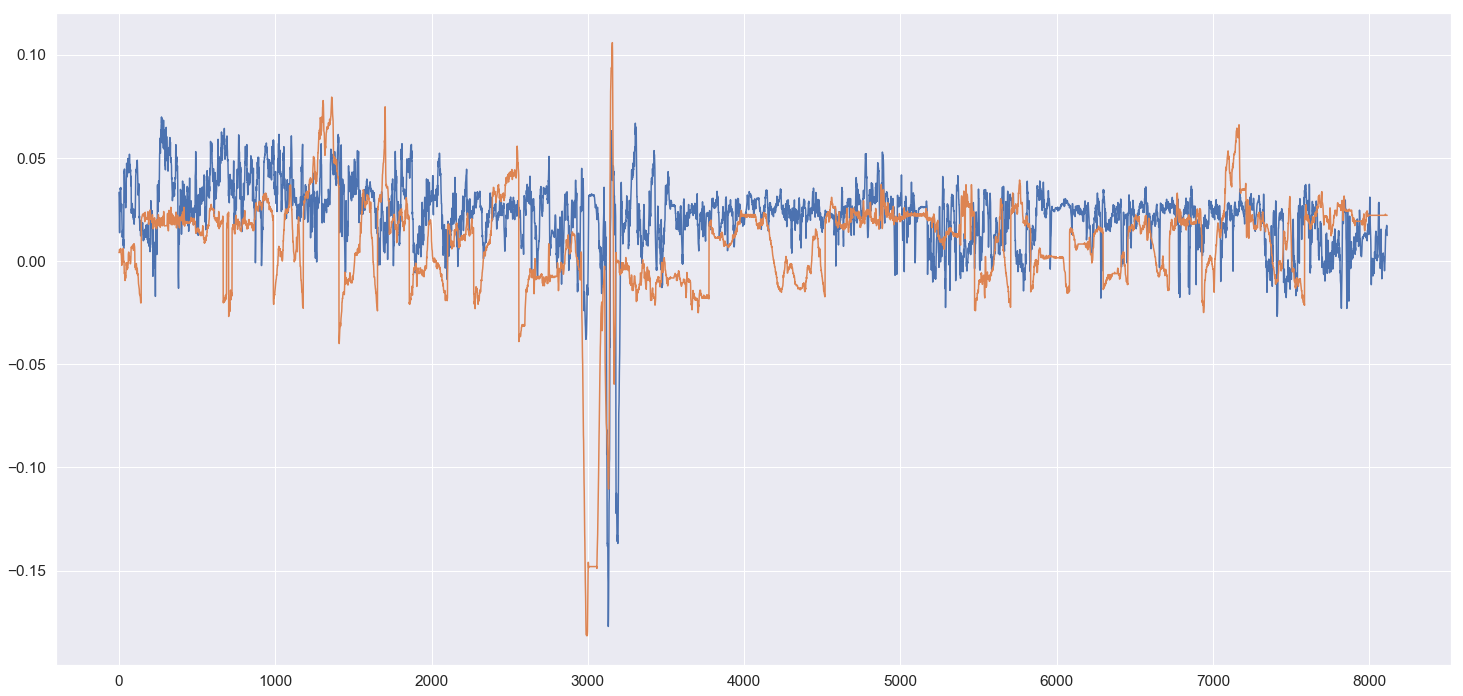

In [20]:
x = np.linspace(0,yhat.shape[0], yhat.shape[0]).reshape(yhat.shape[0],)
pyplot.plot(yhat[:,[1]],'r')
pyplot.plot(test_y[:,[1]],'orange')
error=np.abs(yhat[:,[1]]-test_y[:,[1]])
pyplot.fill_between(x,(yhat[:,[1]]-error).reshape(yhat.shape[0],), (yhat[:,[1]]+error).reshape(yhat.shape[0],))
pyplot.show()
pyplot.plot(yhat[:,[0]])
pyplot.plot(test_y[:,[0]])
pyplot.show()
pyplot.plot(yhat[:,[2]])
pyplot.plot(test_y[:,[2]])
pyplot.show()

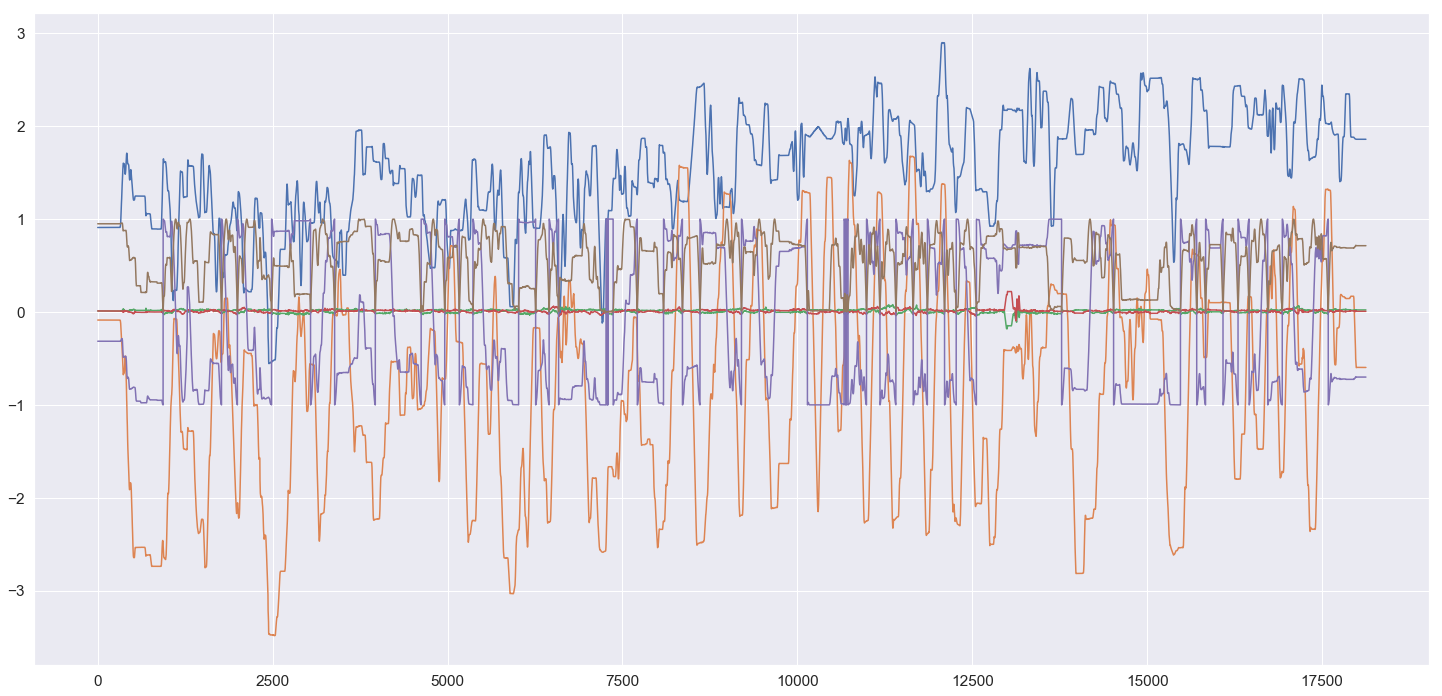

In [21]:
pyplot.plot(gt_sc)
pyplot.show()